In [1]:
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200830_mnist"

In [3]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values(["weight_prior", "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x="weight_prior", y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

In [4]:
runs = []
for config_file in glob(f"../results/{exp_name}/*/eval/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [5]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [6]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,calibration_eval,config_file,cycles,...,auroc_mean,auroc_std,auroc_stderr,lp_mean,lp_std,lp_stderr,ace,ece,rmsce,error_mean
0,True,64,True,0,gaussian,1,10,False,../results/200830_mnist/21/config.json,20,...,0.840339,0.0039193,0.00039193,-7.74296,4.30519,0.0430519,NaN,NaN,NaN,0.937275
1,True,64,True,0,gaussian,1,10,True,../results/200830_mnist/21/config.json,20,...,NaN,NaN,NaN,-0.988195,2.14896,0.012407,0.0262326,0.114851,0.00945122,0.224966
2,True,64,True,0,gaussian,1,10,False,../results/200830_mnist/21/config.json,20,...,NaN,NaN,NaN,-0.0600098,0.323732,0.00323732,NaN,NaN,NaN,0.019548
3,True,64,True,0,gaussian,1,10,False,../results/200830_mnist/69/config.json,20,...,0.796201,0.030212,0.0030212,-6.18247,4.34751,0.0434751,NaN,NaN,NaN,0.922449
4,True,64,True,0,gaussian,1,10,True,../results/200830_mnist/69/config.json,20,...,NaN,NaN,NaN,-0.940073,2.04552,0.0118098,0.0344834,0.163037,0.0123904,0.246398


In [7]:
runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None

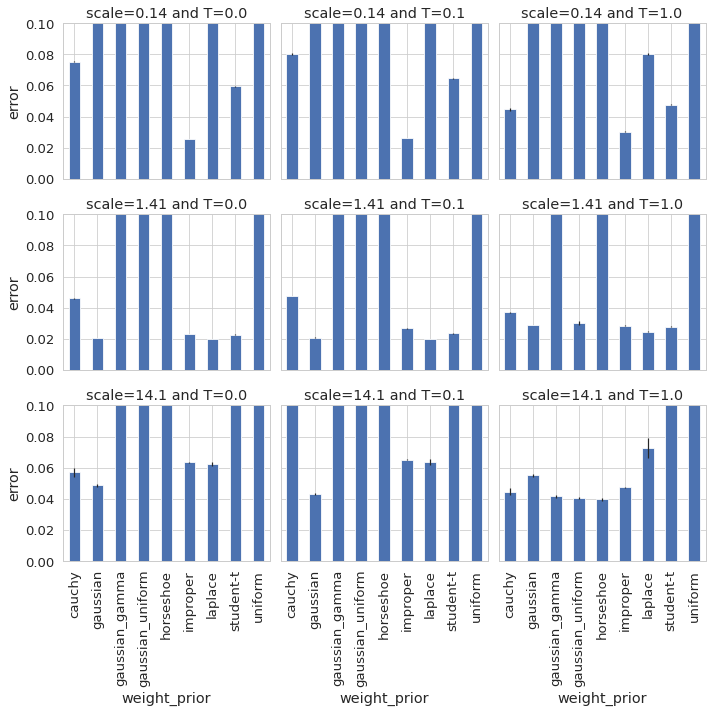

In [8]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [9]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

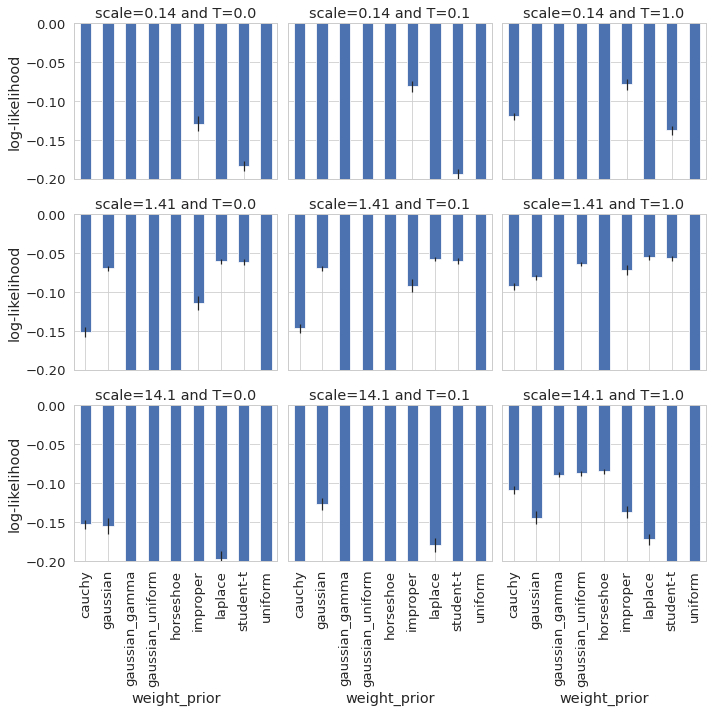

In [10]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [11]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [12]:
runs_selected = runs_all.query("eval_data == 'rotated_mnist'")

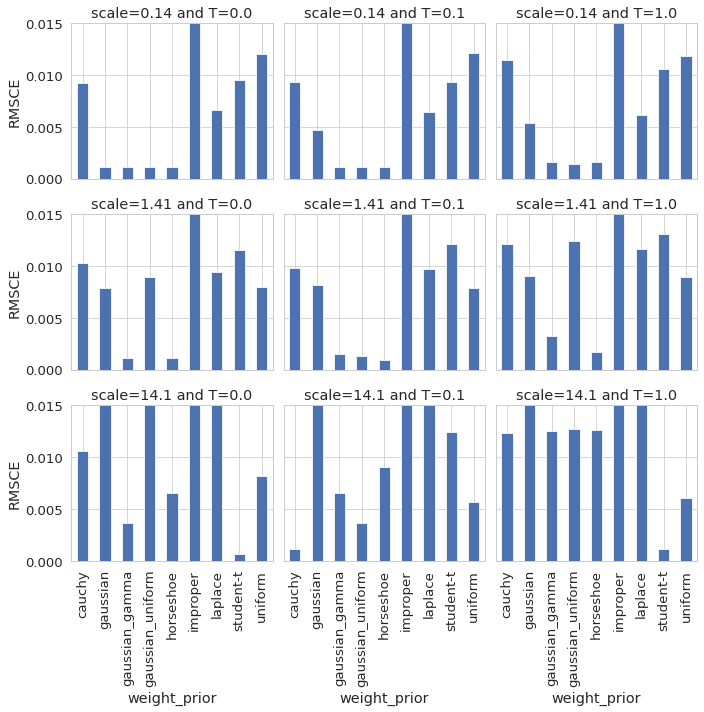

In [13]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [14]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

In [15]:
runs_selected = runs_all.query("eval_data == 'fashion_mnist'")

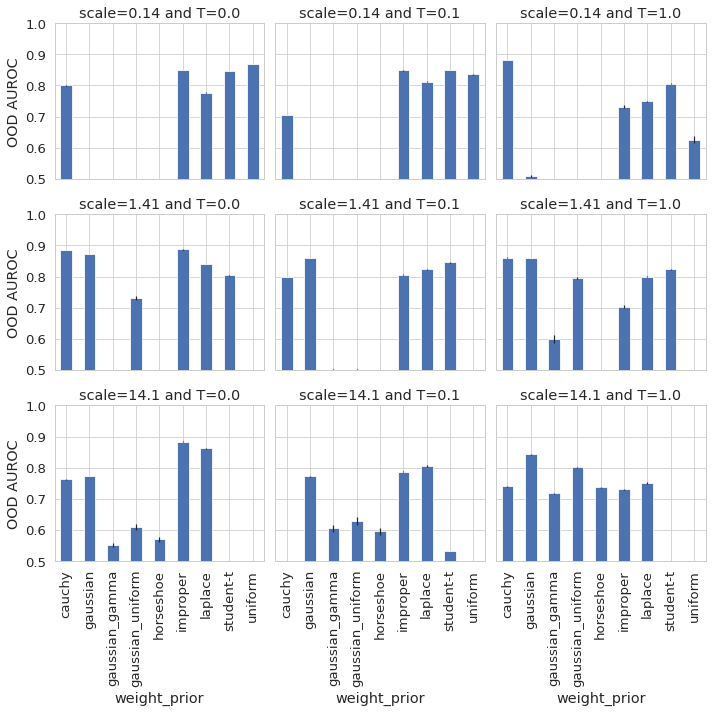

In [16]:
fig = plot_grid(runs_selected, y="auroc_mean", yerr="auroc_stderr", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [17]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")